<a href="https://colab.research.google.com/github/bbberylll/ESAA_OB/blob/main/ESAA_OB_M13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3 : 전이학습
**[특성 추출 기법]**
- 특성 추출: 사전 훈련된 모델을 가져온 후 마지막에 완전 연결층 부분만 새로 만드는 것. **학습 시 마지막 완전 연결층만 학습하고 나머지 계층은 학습X**

- 합성곱층 : 합성곱층과 풀링층으로 구성
- 완전연결층 : 추출된 특성을 받아서 최종적으로 클래스 분류

>> ImageNet으로 이미 훈련한 layer를 가져와서 이미지 분류만 수행하는 것!
  - imageNEt layer의 가중치를 그대로 활용함!



In [1]:
! pip install opencv-python

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision. models as models
import torch.nn as nn
import torch.optim as optim
from torch .utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/gilbutITbook/080289.git

fatal: destination path '080289' already exists and is not an empty directory.


In [3]:
data_path = '/content/080289/chap05/data/catanddog/train'
transform = transforms.Compose(
    [
        transforms.Resize([256, 256]) ,
        transforms.RandomResizedCrop(224) ,
        transforms.RandomHorizontalFlip() ,
        transforms.ToTensor()
])
train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform=transform
)
train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=32,
                num_workers=8,
                shuffle=True
)
print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1. torchvision.transform : 이미지 데이터를 변환해서 모델의 입력이 가능하도록 만들어줌
  - resize = 이미지 크기 조정   >> 합성곱층을 통과하기 위한 용도
  - randomResizedCrop : 이미지를 랜덤한 크기, 비율로 자름  >> 데이터 확장 용도
  - randomHorizontalFlip : 이미지를 랜덤하게 수평으로 뒤집음
  - ToTensor : 텐서로 변환

2. train_loader : 불러올 데이터셋과 한번에 불러올 데이터의 양, 하위 프로세스의 갯수, shuffle 여부 결정 가능

In [5]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.21
    Uninstalling graphviz-0.21:
      Successfully uninstalled graphviz-0.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
google-adk 1.17.0 requires graphviz<1.0.0,>=0.20.2, but you have graphviz 0.8.4

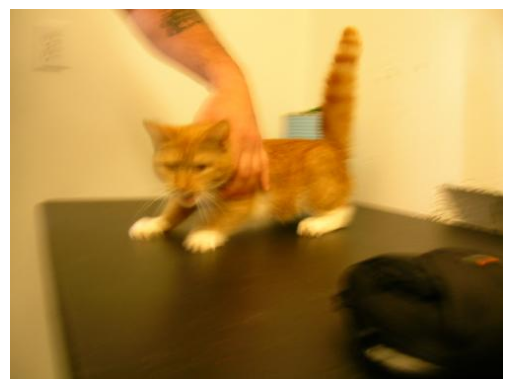

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# 이미지 경로
img_path = '/content/080289/chap05/data/catanddog/train/Cat/0.jpg'

# 이미지 열기
example_image = Image.open(img_path)

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# 변환 적용
example_image_tensor = transform(example_image)

# 시각화
plt.imshow(example_image)
plt.axis('off')
plt.show()


In [5]:
def show_images(imgs , num_rows , num_cols, scale=2):
    aspect_ratio = imgs[0].shape[0]/ imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows , num_cols, figsize=figsize)
    for i in range(num_rows) :
        for j in range(num_cols):
            axes[i ][j ].imshow(imgs[i * num_cols + j ].asnumpy())
            axes [i ] [j ].axes.get_xaxis( ).set_visible( False)
            axes [i ] [j ].axes.get_yaxis( ).set_visible( False)
        plt.subplots_adjust(hspace=0.1 , wspace=0)
        return axes

def apply(img , aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols )]
    show_images (Y, num_rows , num_cols, scale)

    shape_aug = transforms.RandomResizedCrop( size=(200, 200 ),
                                             scale=( 0.1 , 1),
                                              ratio=(0.5, 2))
    apply(example_image, shape_aug )
    shape_aug = transforms.RandomResizedCrop(size=( 200, 200 ),
                                             scale=(0.1,1),
                                             ratio=(0.5,2))


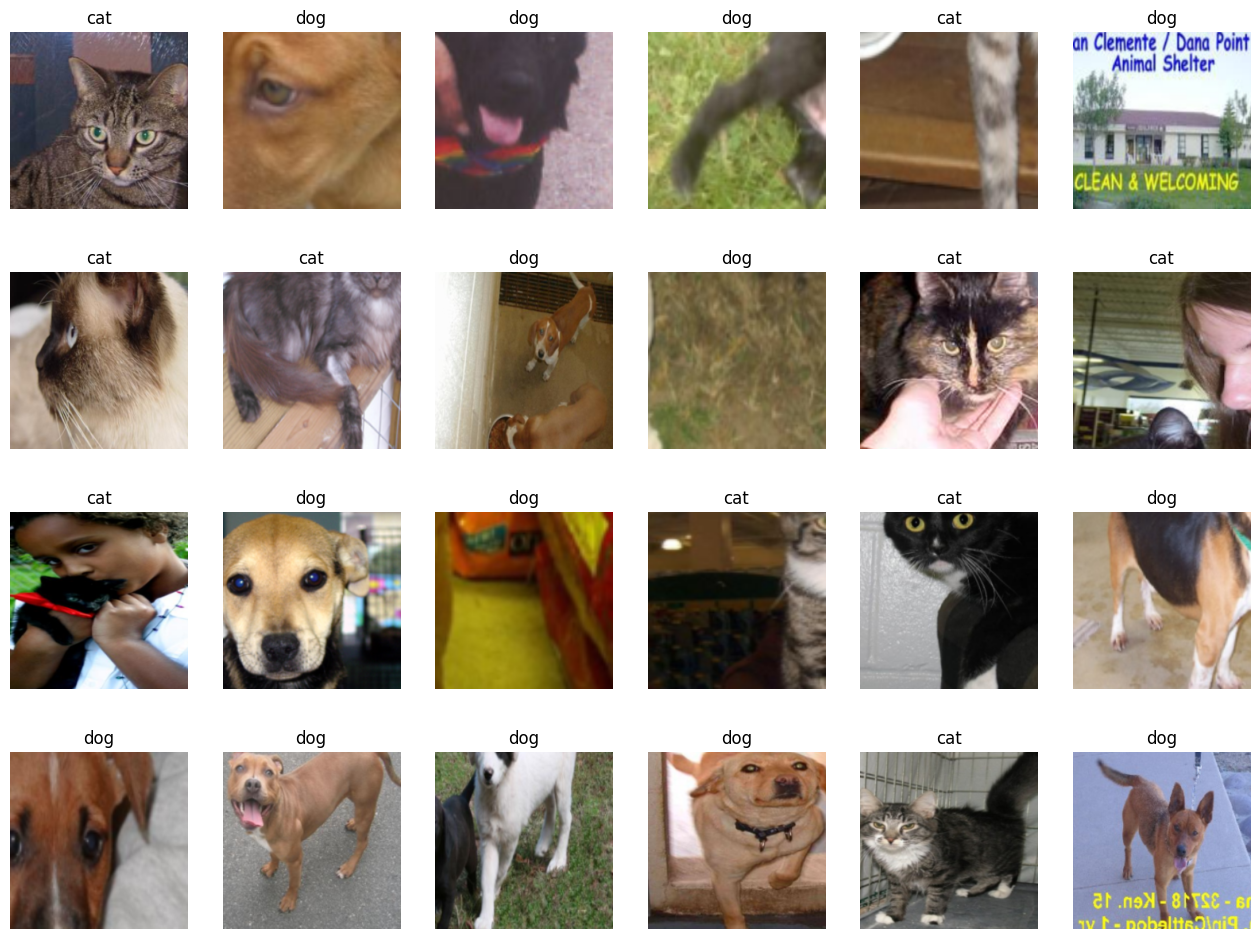

In [29]:
import matplotlib.pyplot as plt
import torch

# DataLoader에서 배치 가져오기
samples, labels = next(iter(train_loader))

classes = {0: 'cat', 1: 'dog'}

fig = plt.figure(figsize=(16, 24))
for i in range(24):  # 앞에서 24개 이미지만
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


1. iter, next : iter()는 들어온 데이터의 반복자를 꺼내서 반환, next()는 그 반복자가 다음에 출력해야 하는 요소를 반환하게 된다.  
  - train_loader에서 sample과 label을 꺼내서 저장함

In [7]:
import numpy as np
exam= np.arange(24).reshape(2,3,4)
exam

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [8]:
np.transpose(exam, (2,1,0))

array([[[ 0, 12],
        [ 4, 16],
        [ 8, 20]],

       [[ 1, 13],
        [ 5, 17],
        [ 9, 21]],

       [[ 2, 14],
        [ 6, 18],
        [10, 22]],

       [[ 3, 15],
        [ 7, 19],
        [11, 23]]])

In [9]:
resnet18 = models.resnet18( pretrained=True )

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


**[ResNet18]**
- 50개의 계층으로 구성된 합성곱 신경망
- 전이 학습에 사용될 수 있는 사전 훈련 모델을 제공함
- 입력 제약이 매우 큼
- 충분한 메모리가 없으면 학습 속도가 느릴 수 있음

In [10]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [11]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True )
alexnet = models.alexnet(pretrained=True )
squeezenet = models.squeezenet1_0 (pretrained=True )
vgg16 = models.vgg16(pretrained=True )
densenet = models.densenet161(pretrained=True )
inception = models.inception_v3(pretrained=True )
googlenet = models.googlenet(pretrained=True )
shufflenet = models.shufflenet_v2_x1_0( pretrained=True)
mobilenet_v2 = models.mobilenet_v2( pretrained=True )
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True )
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True )
resnext50_32x4d = models.resnext50_32x4d( pretrained=True )
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True )
mnasnet = models .mnasnet1_0( pretrained=True )

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 149MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 55.3MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 77.4MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


100%|██████████| 110M/110M [00:00<00:00, 164MB/s] 
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 154MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 153MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 84.0MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 90.4MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 109MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 85.7MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


100%|██████████| 95.8M/95.8M [00:01<00:00, 84.2MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


100%|██████████| 132M/132M [00:00<00:00, 151MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


100%|██████████| 16.9M/16.9M [00:00<00:00, 109MB/s] 


In [12]:
def set_parameter_requires_grad(model , feature_extracting=True ):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

사전 훈련된 layer의 파라미터를 그대로 재활용하기 때문에 **역전파 중 파라미터 변화를 계산할 필요가 없음**을 명시적으로 알려준다!
> require_grad = False로 설정!

In [13]:
resnet18.fc=nn.Linear(512,2)

**[완전연결층] 추가 과정**

2는 클래스가 2개라는 의미임

In [14]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0356, -0.0289, -0.0415,  ..., -0.0318,  0.0271, -0.0378],
        [-0.0083,  0.0361,  0.0374,  ..., -0.0112,  0.0388,  0.0428]])
fc.bias tensor([ 0.0084, -0.0160])


In [15]:
model = models.resnet18( pretrained=True )

for param in model.parameters ():
    param.requires_grad=False

model.fc=torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad=True

optimizer=torch.optim.Adam(model.fc.parameters())
cost=torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
def train_model(model , dataloaders, criterion, optimizer, device,
                num_epochs=13, is_train=True ):
    since = time.time()   ## 컴퓨터로 현재 시각 구함
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs ):   ## 에포크 설정
        print( 'Epoch {} /{} '.format(epoch , num_epochs-1))
        print('- ' * 10)
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:   ## 데이터 로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)   ## 순전파 학습
            loss=criterion(outputs,labels)
            _, preds = torch.max( outputs, 1)
            loss.backward()   ## 역전파 학습 과정
            optimizer.step()

            running_loss += loss . item() * inputs.size(0)
            running_corrects += torch.sum( preds == labels.data)

        epoch_loss = running_loss / len (dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print( 'Loss: {:.4f} Acc: {:.4f} '.format(epoch_loss, epoch_acc ))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join( '/content/080289/chap05/data/catanddog',    '{0:0=2d}.pth'.format(epoch)))
        print()


    time_elasped= time.time() - since
    print( 'Training complete in {:.0f}m {:.0f}s '.format(time_elasped // 60,
                                                      time_elasped % 60))
    print( 'Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [17]:
params_to_update = []
for name , param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update . append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader,
                                              criterion, optimizer, device)

Epoch 0 /12 
- - - - - - - - - - 
Loss: 0.5445 Acc: 0.7039 

Epoch 1 /12 
- - - - - - - - - - 
Loss: 0.3678 Acc: 0.8701 

Epoch 2 /12 
- - - - - - - - - - 
Loss: 0.3085 Acc: 0.8961 

Epoch 3 /12 
- - - - - - - - - - 
Loss: 0.3193 Acc: 0.8494 

Epoch 4 /12 
- - - - - - - - - - 
Loss: 0.2705 Acc: 0.8779 

Epoch 5 /12 
- - - - - - - - - - 
Loss: 0.2458 Acc: 0.9039 

Epoch 6 /12 
- - - - - - - - - - 
Loss: 0.2511 Acc: 0.8883 

Epoch 7 /12 
- - - - - - - - - - 
Loss: 0.2106 Acc: 0.9117 

Epoch 8 /12 
- - - - - - - - - - 
Loss: 0.2110 Acc: 0.9169 

Epoch 9 /12 
- - - - - - - - - - 
Loss: 0.2163 Acc: 0.9143 

Epoch 10 /12 
- - - - - - - - - - 
Loss: 0.2061 Acc: 0.9169 

Epoch 11 /12 
- - - - - - - - - - 
Loss: 0.1877 Acc: 0.9247 

Epoch 12 /12 
- - - - - - - - - - 
Loss: 0.2456 Acc: 0.8779 

Training complete in 8m 51s 
Best Acc: 0.924675


In [19]:
test_path ='/content/080289/chap05/data/catanddog/test'


transform = transforms.Compose(
    [
        transforms.Resize(224) ,
        transforms.CenterCrop(224),
        transforms.ToTensor() ,
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)
print (len(test_dataset))

98


In [20]:
def eval_model (model , dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/080289/chap05/data/catanddog_5' +
    '*.pth')
    saved_models.sort()
    print('saved_model' , saved_models )

    for model_path in saved_models:
        print( 'Loading model' , model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds [preds >= 0.5] = 1
            preds [preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print( 'Acc: {:.4f} '.format(epoch_acc ))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            acc_history.append(epoch_acc.item())
            print()
    time_elapsed = time.time() - since
    print ('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60 ,
            time_elapsed % 60 ))
    print( 'Best Acc: {:.4f}'.format(best_acc))
    return acc_history

1. glob : 현재 디렉토리에서 **원하는 파일만 가져오고 싶을 때** 사용함

2. torch.max : 텐서 배열의 최댓값의 index를 반환함

3. preds.eq(labels) : preds와 labels가 일치하는지 검사함 + sum()을 통해 정답을 맞춘 갯수를 구해줌

In [21]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model []
Validation complete in 0m 0s
Best Acc: 0.0000


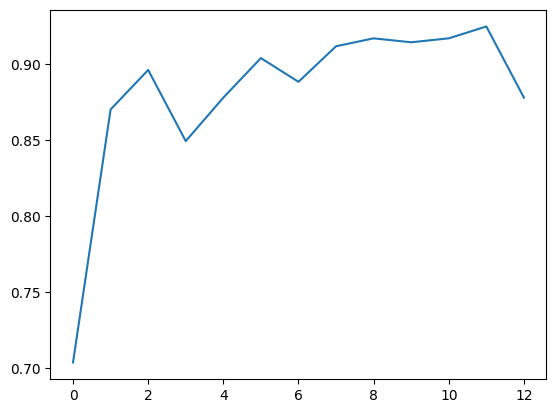

In [22]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

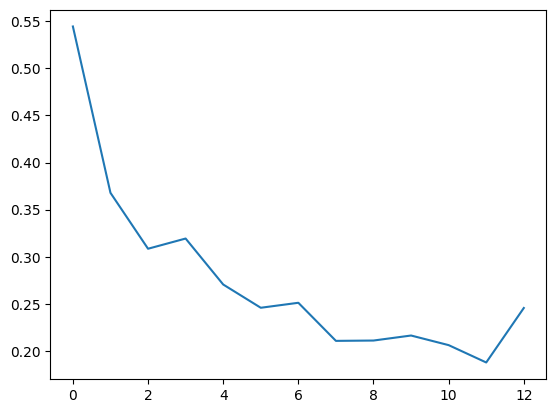

In [23]:
plt.plot(train_loss_hist)
plt.show()

In [24]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip( 0, 1)
    return image

1. tensor.clone : 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미

2. detach : 기존 텐서에서 기울기가 전파되지 않는 텐서임

> 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에는 영향을 주지 않겠다는 의미!


In [25]:
import numpy as np
exam=np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5))

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9]
[-0.5 -0.5 -0.5  0.   0.5  0.5  0.5]


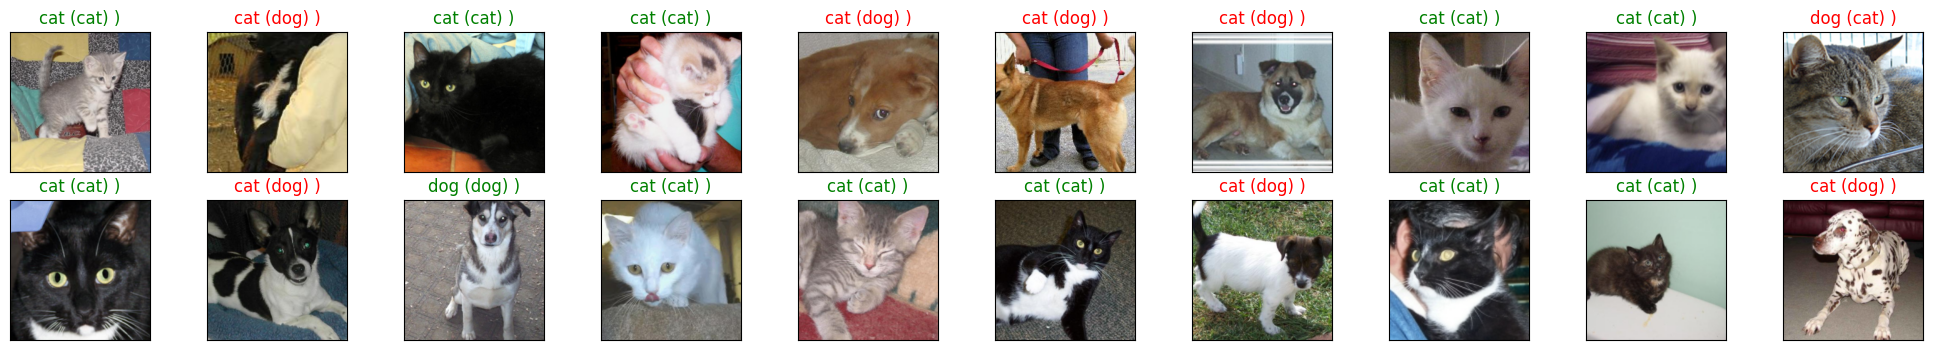

<Figure size 640x480 with 0 Axes>

In [26]:
classes = {0: 'cat' , 1: 'dog' }

dataiter = iter(test_loader)
images , labels = next(dataiter)
output = model( images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1 , xticks=[] , yticks=[])
    plt.imshow (im_convert(images [idx ] ))
    ax.set_title(classes[labels[i].item()])
    ax.set_title("{} ({}) )".format(str(classes[preds[idx ].item()]),
                                    str(classes[labels[idx].item()])),
                 color=( "green" if preds [idx]==labels[idx ] else "red" ))

plt. show()
plt. subplots_adjust(bottom=0.2, top=0.6, hspace=0)